# Discrete grid world

In this notebook, we perform UQ via PCE-surrogate modelling for GFNs.

First, import the neccessary libraries.

In [20]:
from matplotlib import pyplot as plt
from torch.distributions import Normal, Categorical
import math
import numpy as np
import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.distributions.categorical import Categorical
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import tqdm
import torch.optim as optim
from collections import Counter
import networkx as nx
from collections import deque
from tqdm import tqdm
import pandas as pd
import random
from matplotlib.colors import LogNorm
if not hasattr(np, 'bool'):
    np.bool = bool
import chaospy as chaos
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import time
import pyro.poutine as poutine
from pyro.poutine import trace
import torch
import discrete_grid_helpers as h
import importlib
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model as lm
from scipy.stats import gaussian_kde
from scipy.special import softmax
import matplotlib.lines as mlines
import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set(font='Times New Roman', style = 'white')

We sample random reward grids according to our stochastic procedure

In [3]:
no_grid_samples = 500
new_high_reward_centers_list = [h.shift_reward_centers(0.4) for i in range(0,no_grid_samples)]
numpy_grids = [h.create_reward_grid(h.grid_size,high_reward_centers,h.high_reward,h.mid_reward,h.low_reward) for high_reward_centers in new_high_reward_centers_list]
training_data = h.create_one_hot_training_data(numpy_grids,h.grid_size)

We then train the $\beta$-VAE to embed these grids in a latent space

In [4]:
train_dataset = TensorDataset(training_data, torch.zeros(training_data.shape[0]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

latent_dim = 2

beta = 4

pyro.clear_param_store()
    
vae = h.VAE(latent_dim=latent_dim,beta = beta)

optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# Training loop
epochs = 1000
print("Starting training")
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0.
    for x_batch, _ in train_loader:
        if x_batch.dim() == 4 and x_batch.shape[1] == 3:
            x_batch_indices = torch.argmax(x_batch, dim=1).view(x_batch.shape[0], -1)
        elif x_batch.dim() == 3 and x_batch.shape[-1] == 3:
            x_batch_indices = torch.argmax(x_batch, dim=-1)

        batch_loss = svi.step(x_batch, x_batch_indices)
        epoch_loss += batch_loss
            
    end_time = time.time()
    normalizer = len(train_loader.dataset)
    total_epoch_loss = epoch_loss / normalizer
    if np.mod(epoch,100) == 0:
        print(f"Epoch {epoch} Loss: {total_epoch_loss:.4f} (took {end_time - start_time:.2f}s)")

print("Training finished!")

Starting training
Epoch 0 Loss: 105.4204 (took 1.25s)
Epoch 100 Loss: 28.8257 (took 0.14s)
Epoch 200 Loss: 25.6048 (took 0.14s)
Epoch 300 Loss: 24.5146 (took 0.15s)
Epoch 400 Loss: 23.9445 (took 0.14s)
Epoch 500 Loss: 24.0196 (took 0.15s)
Epoch 600 Loss: 23.7155 (took 0.15s)
Epoch 700 Loss: 23.9588 (took 0.15s)
Epoch 800 Loss: 23.6533 (took 0.14s)
Epoch 900 Loss: 23.7361 (took 0.14s)
Training finished!


We can then build up a picture of the latent space by taking samples from the latent distributions associated with each reward grid.

In [5]:
n_samples_per_data_point = 100
grid_embeddings_dist = []
grid_embeddings_points = []
latent_samples = np.zeros((n_samples_per_data_point*len(numpy_grids),latent_dim))

for n, grid in enumerate(numpy_grids):
    latent_dist = h.get_latent_representation_dist(vae, grid,grid_size=10)
    x_mu, y_mu = latent_dist[0][0]
    x_logvar, y_logvar = latent_dist[1][0]
    
    grid_embeddings_dist.append(latent_dist)
    grid_embeddings_points.append(latent_dist[0][0])

    x_std = np.sqrt(np.exp(x_logvar))
    y_std = np.sqrt(np.exp(y_logvar))

    for j in range(n_samples_per_data_point):
        z_x = np.random.normal(x_mu, x_std)
        z_y = np.random.normal(y_mu, y_std)
        latent_samples[n * n_samples_per_data_point + j, :] = [z_x, z_y]

We can plot the latent space.

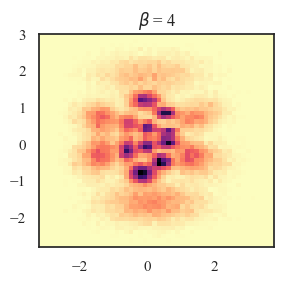

In [6]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(3,3)

_ = ax.hist2d(latent_samples[:,0],latent_samples[:,1],bins = 50, cmap = 'magma_r')

ax.set_title(r'$\beta$ = ' + str(beta))

plt.tight_layout()
plt.show()

We approximate the latent space with a maximum-likelihood Gaussian distribution with diagonal covariance.

In [7]:
x_mean, y_mean = np.mean(latent_samples,0)
Sigma = np.cov(latent_samples.T)
print('Gaussian approximation of latent space')
print(x_mean, y_mean)
print(np.diag(np.diag(Sigma)))

Gaussian approximation of latent space
0.049662966831998404 0.011010110978677864
[[0.94226093 0.        ]
 [0.         1.05142048]]


We import a pretrained ensemble of GFN models that solve the grid world.

In [ ]:
grid_size = 10
max_length = 2*grid_size
state_dim = grid_size * grid_size + 2
action_space_size = 5

model_ensemble = []

N = 50

for n in range(N):
    model = h.GFlowNet(state_dim=state_dim,action_space_size=action_space_size)
    state_dict = torch.load('training_ensemble/gfn' + str(n+1) + '.pth')
    model.load_state_dict(state_dict)
    model.eval()
    model_ensemble.append(model)

We can either sample a path from the model, or we can import some previously sampled trajectory. We then extract the policy along this trajectory for each model in the ensemble.

In [10]:
paths, actions_list = h.meta_model_sampler(model_ensemble, h.env,n_samples=1, max_length=max_length)
sampled_path = np.array(paths[0])

sampled_path = np.loadtxt('sampled_path.csv',dtype=int)
actions_list = [list(np.loadtxt('actions_list.csv',dtype=int))]
actions = actions_list[0]
actions.append(4)

flows = h.ensemble_flows_along_traj(model_ensemble,h.env,sampled_path,actions_list[0])
policy = h.policy_along_traj(model,h.env,sampled_path)
ensemble_policy = h.enesemble_policy_along_traj(model_ensemble,h.env,sampled_path)

/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/3228285265.py:4: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  sampled_path = np.loadtxt('sampled_path.csv',dtype=int)
/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/3228285265.py:5: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).

We need to import the reward function associated with each model in our ensemble, which we can run through our trained VAE to embed them in the latent space.

In [ ]:
N = 50

grid_embeddings_dist = []
grid_embeddings_points = []

for n in range(N):
    grid = np.array(pd.read_csv('training_ensemble/grid'+str(n+1)+'.csv',header=None))
    grid_embeddings_dist.append(h.get_latent_representation_dist(vae, grid,grid_size))
    grid_embeddings_points.append(h.get_latent_representation(vae, grid,grid_size))
    
grid_embeddings_points = np.array(grid_embeddings_points).reshape(50,latent_dim)

We create training data, by taking a number of samples-per-grid, and taking the logit transform to project probabilities onto the real line.

In [12]:
def logit(y):
    return np.log(y/(1-y))

def sigmoid(x):
    return 1/(1+np.exp(-x))

epsilon = 1e-10
A_safe = np.where(ensemble_policy == 0, epsilon, ensemble_policy)
logit_ensemble_policy = logit(A_safe)

n_samples_per_data_point = 20

latent_training_samples = np.zeros((n_samples_per_data_point*N,latent_dim))
latent_training_policies = np.zeros((n_samples_per_data_point*N,logit_ensemble_policy.shape[1],logit_ensemble_policy.shape[2]))

for ix, dist in enumerate(grid_embeddings_dist):

    x_mu, y_mu = dist[0][0]
    x_logvar, y_logvar = dist[1][0]
    
    x_std = np.sqrt(np.exp(x_logvar))
    y_std = np.sqrt(np.exp(y_logvar))

    for j in range(n_samples_per_data_point):
        z_x = np.random.normal(x_mu, x_std)
        z_y = np.random.normal(y_mu, y_std)
        latent_training_samples[ix * n_samples_per_data_point + j, :] = [z_x, z_y]
        latent_training_policies[ix * n_samples_per_data_point + j, :,:] = logit_ensemble_policy[ix,:,:]

To construct the PCE, we construct an orthonormal polynomial basis, with respect to the Gaussian approximation that we made earlier.

In [13]:
degree = 7

q0, q1 = chaos.numpoly.variable(2)

hermite_1 = chaos.expansion.hermite(degree, mu=x_mean, sigma=np.sqrt(Sigma[0,0]),normed=False)
hermite_2 = chaos.expansion.hermite(degree, mu=y_mean, sigma=np.sqrt(Sigma[1,1]),normed=False)

hermite1 = hermite_1(q0)
hermite2 = hermite_2(q1)

outer_product_basis = chaos.outer(hermite1, hermite2).flatten()
polynomial_basis = outer_product_basis[np.sum(outer_product_basis.exponents, axis=1) <= degree]

We then fit the PCE coefficients using Ridge regression.

In [14]:
coefficients = []

all_zeros = []

for i in range(latent_training_policies.shape[1]):
    coeff_temp_list = []
    for j in range(latent_training_policies.shape[2]):
        A = polynomial_basis(*latent_training_samples.T)
        A = A.T
        
        # if a move is impossible, then don't do the PCE as it is unstable
        if np.all(ensemble_policy[:,i,j]==0):
            all_zeros.append((i,j))
            coeff_temp_list.append([])
        else:
            model = RidgeCV(cv=5,fit_intercept=False).fit(A, latent_training_policies[:,i,j])
            coeffs = model.coef_
            coeff_temp_list.append(coeffs)
    coefficients.append(coeff_temp_list)

Now that our surrogate model is trained, we can sample surrogate outputs at new input samples. We use the samples that we generated earlier from the VAE, but we could just as well sample new grids and run them through the encoder. 

We also transform the surrogate outputs back into a probability output with the softmax.

In [16]:
output = np.zeros((latent_samples.shape[0],latent_training_policies.shape[1],latent_training_policies.shape[2]))
prob_output_sigmoid = np.zeros((latent_samples.shape[0],latent_training_policies.shape[1],latent_training_policies.shape[2]))
prob_output_softmax = np.zeros((latent_samples.shape[0],latent_training_policies.shape[1],latent_training_policies.shape[2]))

def pce_surrogate(x_new, orthogonal_expansion, coeffs):
    basis_evals = orthogonal_expansion(*x_new)
    return coeffs @ basis_evals

for i in range(latent_training_policies.shape[1]):
    for j in range(latent_training_policies.shape[2]):
        if (i,j) not in all_zeros:
            output[:,i,j] = pce_surrogate(latent_samples.T,polynomial_basis,coefficients[i][j])
            prob_output_sigmoid[:,i,j] = sigmoid(output[:,i,j]) # we have to run this in the loop otherwise the sigmoid will send all the 0 to 0.5
        else:
            output[:,i,j] = -np.inf
    prob_output_softmax[:,i,:] = softmax(output[:,i,:],axis=1)

To evaluate the surrogate outputs, we want to compare to a testing ensemble that was not used in the training of the PCE.

In [18]:
grid_size = 10
max_length = 2*grid_size
state_dim = grid_size * grid_size + 2
action_space_size = 5

test_model_ensemble = []

N = 100

for n in range(N):
    model = h.GFlowNet(state_dim=state_dim,action_space_size=action_space_size)
    state_dict = torch.load('testing_ensemble/test_gfn' + str(n) + '.pth')
    model.load_state_dict(state_dict)
    model.eval()
    test_model_ensemble.append(model)

test_grid_embeddings_dist = []
test_grid_embeddings_points = []

for n in range(N):
    grid = np.array(pd.read_csv('testing_ensemble/test_grid'+str(n)+'.csv',header=None))
    test_grid_embeddings_dist.append(h.get_latent_representation_dist(vae, grid,grid_size))
    test_grid_embeddings_points.append(h.get_latent_representation(vae, grid,grid_size))
    
test_grid_embeddings_points = np.array(test_grid_embeddings_points).reshape(N,latent_dim)

test_flows = h.ensemble_flows_along_traj(test_model_ensemble,h.env,sampled_path,actions_list[0])
test_ensemble_policy = h.enesemble_policy_along_traj(test_model_ensemble,h.env,sampled_path)

We then plot both the testing and surrogate policies along the trajectory.

/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/2078862445.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(category_labels, rotation=90)
/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/2078862445.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(category_labels, rotation=90)
/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/2078862445.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[k].set_xticklabels(category_labels, rotation=90)
/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_93729/2078862445.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

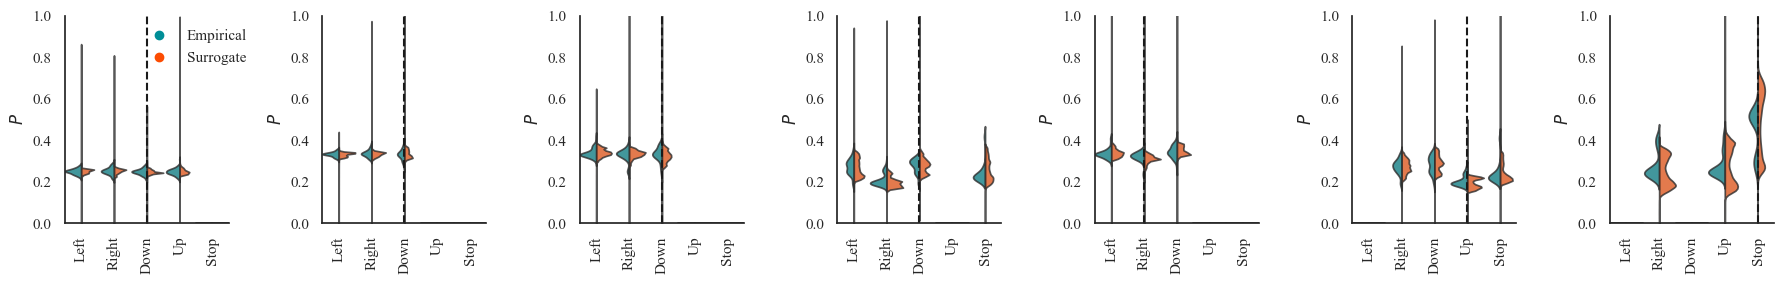

In [19]:
cols = ['#008E97', '#FC4C02']
category_labels = ['Left','Right','Down','Up','Stop']

fig, ax = plt.subplots(1, 7, figsize=(18, 3))

for k in range(7):
    # Prepare long-form DataFrame for split violin
    df_list = []
    for i, label in enumerate(['Empirical','Surrogate']):
        data = prob_output_softmax[:, k, :] if label == 'Surrogate' else test_ensemble_policy[:, k, :]
        df = pd.DataFrame(data, columns=category_labels)
        df = df.melt(var_name='Action', value_name='Probability')
        df['Type'] = label
        df_list.append(df)
    
    df_combined = pd.concat(df_list, ignore_index=True)
    
    sns.violinplot(
        data=df_combined, x='Action', y='Probability', hue='Type',
        split=True, palette=cols, alpha=0.8, ax=ax[k], inner=None,legend=False,width=1
    )

    ax[k].set_ylim([0, 1])
    ax[k].axvline(actions[k], color='k', linestyle='dashed')
    ax[k].set_xlabel('')
    ax[k].set_ylabel(r'$P$')
    #ax[k].set_title(r'$(x,y) = $' + f'({sampled_path[k][0]},{sampled_path[k][1]})')
    ax[k].set_xticklabels(category_labels, rotation=90)


# --- add legend to the first plot ---
empirical_dot = mlines.Line2D([], [], color=cols[0], marker='o', linestyle='None',
                              markersize=6, label="Empirical")
pce_dot = mlines.Line2D([], [], color=cols[1], marker='o', linestyle='None',
                        markersize=6, label="Surrogate")


ax[0].legend(
    handles=[empirical_dot, pce_dot],
    loc='upper left',
    bbox_to_anchor=(0.4, 1),
    frameon=False
)

sns.despine()
plt.tight_layout()
plt.show()

## Comparison with multilayer perceptrons

We want to compare this a surrogate model defined by a multilayer perceptron (MLP)

In [21]:
class MLPPolicy(nn.Module):
    def __init__(self, hidden_sizes=[64, 64], num_actions=5):
        super().__init__()
        layers = []
        input_dim = 2
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, num_actions))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x)
        return logits

We train this model on the same data as before.

In [22]:
models = []

for i in range(0,7):
    dataset = torch.utils.data.TensorDataset(
    torch.tensor(latent_training_samples, dtype=torch.float32),
    torch.tensor(latent_training_policies[:, i, :], dtype=torch.float32)
)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    model = MLPPolicy()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(50):
        for xb, yb in dataloader:
            # Step 1: Get the predicted logits from the model
            pred_logits = model(xb)
            
            log_probs = F.log_softmax(pred_logits, dim=-1)
            
            target_probs = F.softmax(yb, dim=-1)
            
            loss = F.kl_div(log_probs, target_probs, reduction="batchmean")
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch}, loss = {loss.item():.4f}")
    
    models.append(model)

epoch 0, loss = 0.0473
epoch 1, loss = 0.0099
epoch 2, loss = 0.0055
epoch 3, loss = 0.0027
epoch 4, loss = 0.0065
epoch 5, loss = 0.0028
epoch 6, loss = 0.0064
epoch 7, loss = 0.0018
epoch 8, loss = 0.0055
epoch 9, loss = 0.0023
epoch 10, loss = 0.0023
epoch 11, loss = 0.0047
epoch 12, loss = 0.0011
epoch 13, loss = 0.0031
epoch 14, loss = 0.0046
epoch 15, loss = 0.0023
epoch 16, loss = 0.0053
epoch 17, loss = 0.0036
epoch 18, loss = 0.0047
epoch 19, loss = 0.0046
epoch 20, loss = 0.0033
epoch 21, loss = 0.0028
epoch 22, loss = 0.0028
epoch 23, loss = 0.0010
epoch 24, loss = 0.0039
epoch 25, loss = 0.0050
epoch 26, loss = 0.0022
epoch 27, loss = 0.0037
epoch 28, loss = 0.0030
epoch 29, loss = 0.0036
epoch 30, loss = 0.0025
epoch 31, loss = 0.0023
epoch 32, loss = 0.0055
epoch 33, loss = 0.0012
epoch 34, loss = 0.0030
epoch 35, loss = 0.0028
epoch 36, loss = 0.0020
epoch 37, loss = 0.0055
epoch 38, loss = 0.0032
epoch 39, loss = 0.0009
epoch 40, loss = 0.0013
epoch 41, loss = 0.0020
ep

Then predict the outputs at the same input samples.

In [23]:
outputs = np.zeros((latent_samples.shape[0], 7, 5), dtype=np.float32)

for i in range(0,7):
    model = models[i]
    with torch.no_grad():
        preds = model(torch.tensor(latent_samples, dtype=torch.float32))
    outputs[:, i, :] = preds.numpy()

outputs_tensor = torch.from_numpy(outputs)
mlp_ouputs = F.softmax(outputs_tensor, dim=-1).numpy()

We then plot these three sets of policy outputs together.

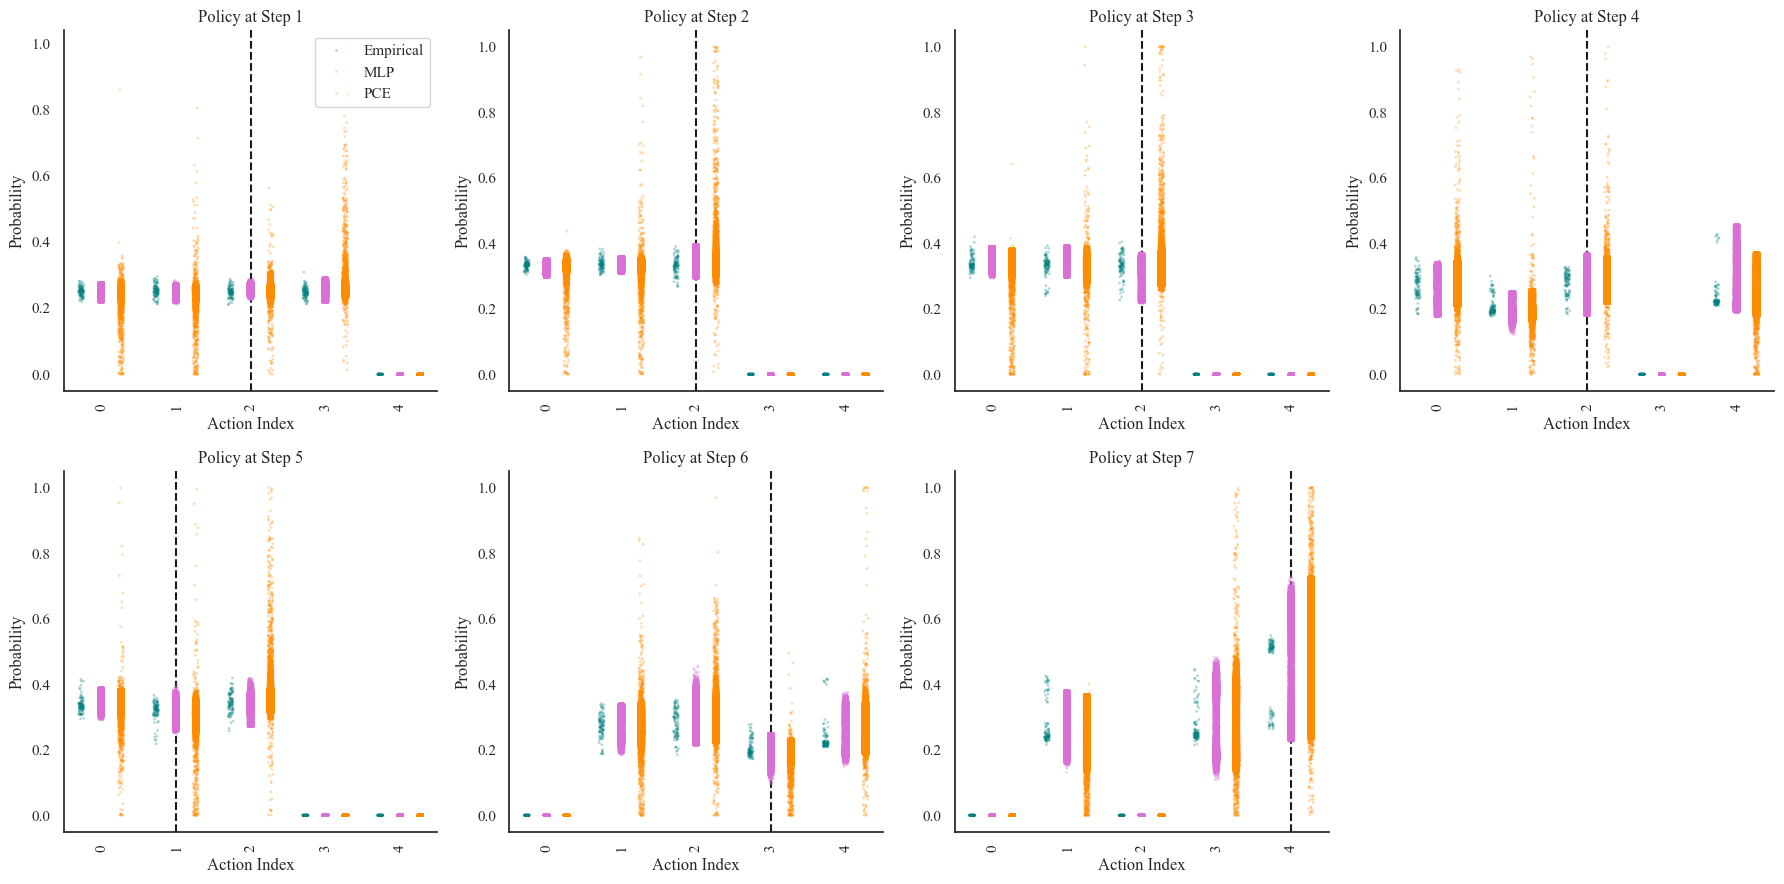

In [24]:
cols = ['#008E97', '#FC4C02']
fig, ax = plt.subplots(2, 4, figsize=(18, 9))

ax[1, 3].axis("off")

for n in range(7):
    idx = n
    i = idx // 4
    j = idx % 4

    data_n = test_ensemble_policy[:, n, :]
    mlp_n = mlp_ouputs[:, n, :]
    surrogate_n = prob_output_softmax[:, n, :]

    df_emp = pd.DataFrame(data_n).melt(var_name="Action", value_name="Probability")
    df_emp["Source"] = "Empirical"

    df_mlp = pd.DataFrame(mlp_n).melt(var_name="Action", value_name="Probability")
    df_mlp["Source"] = "MLP"

    df_sur = pd.DataFrame(surrogate_n).melt(var_name="Action", value_name="Probability")
    df_sur["Source"] = "PCE"

    df_all = pd.concat([df_emp, df_mlp, df_sur], ignore_index=True)

    sns.stripplot(
        data=df_all, x="Action", y="Probability", hue="Source",
        dodge=True, jitter=True, alpha=0.3,
        palette={"Empirical": "teal", "MLP": "orchid", "PCE": "darkorange"},
        ax=ax[i, j],
        rasterized=True,
        s = 2
    )

    ax[i, j].tick_params(axis="x", rotation=90)
    ax[i, j].set_title(f"Policy at Step {n+1}")
    ax[i, j].set_xlabel("Action Index")
    ax[i, j].set_ylabel("Probability")
    ax[i, j].axvline(actions[n], color='k', linestyle='dashed')


    if n == 0:  
        ax[i, j].legend(loc="upper right")
    else:
        ax[i, j].get_legend().remove()

sns.despine()
plt.tight_layout()
plt.show()